# Machine Learning - Practical 3 - Multiclass Logistic Regression, MLP and CNNs


Names: {YOUR NAMES}  
Summer Term 2023   
Due Date: Tuesday, May 30, 2pm

**Please note that this practical requires training a lot of models, which may be time consuming (~2h)**

In this practical we will implement multiclass classification with classic Logistic Regression, Multilayer Preceptron, and the convolutional neural network LeNet5 on image data. We will compare the performance of these models. You will work on the following:

 1. Imports and Hardware check
 2. Loading data and related transformations 
 3. Defining training helper functions and metrics 
 4. Logistic Regression 
 5. MLP
 6. CNN
 7. Comparison of results across models

We'll be storing all the losses and accuracies while training, and plotting everything in the end. Use `tqdm` to keep track of your training and validation losses and accuracies since we're only plotting them in the end.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import seaborn as sns
from torch.utils.data import random_split
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Define data transformations

We will work with the CIFAR-10 dataset, an established computer vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The goal of this dataset is to predict the image class.

Note: The constants in `transforms.Normalize()` are the means and standard deviations of the three color channels of the images in the CIFAR-10 training set. You can verify these numbers yourself by re-computing them.

In [3]:
batch_size = 256

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Load the data and transform the dataset
train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)

### this was somehow missing?!? Split train_dataset into training and validation datasets
train_size = int(0.9 * len(train_dataset))  # 90% for training
val_size = len(train_dataset) - train_size  # 10% for validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.  

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# TODO: make dataloaders (from torch.utils) from datasets, define batch size and do not forget shuffling 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)



In [6]:
## TODO: plot images with their labels after augmentations
def show_batch(dl):
    # Get next image and label batch from dataloader
    images, labels = next(iter(dl))
    
    # Denormalize the images
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    images = images * std[:, None, None] + mean[:, None, None]
    
    # Convert tensor images to numpy arrays
    images = images.numpy()
    labels = labels.numpy()
    
    # Create subplot grid
    fig, axes = plt.subplots(figsize=(10, 10), nrows=8, ncols=8)
    fig.tight_layout()
    
    # Class labels
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    # Iterate over batch and plot each image and label
    for i, ax in enumerate(axes.flat):
        # Plot image
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.axis('off')
        
        # Set label as title
        ax.set_title(class_labels[labels[i]])
    
    # Display plot
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

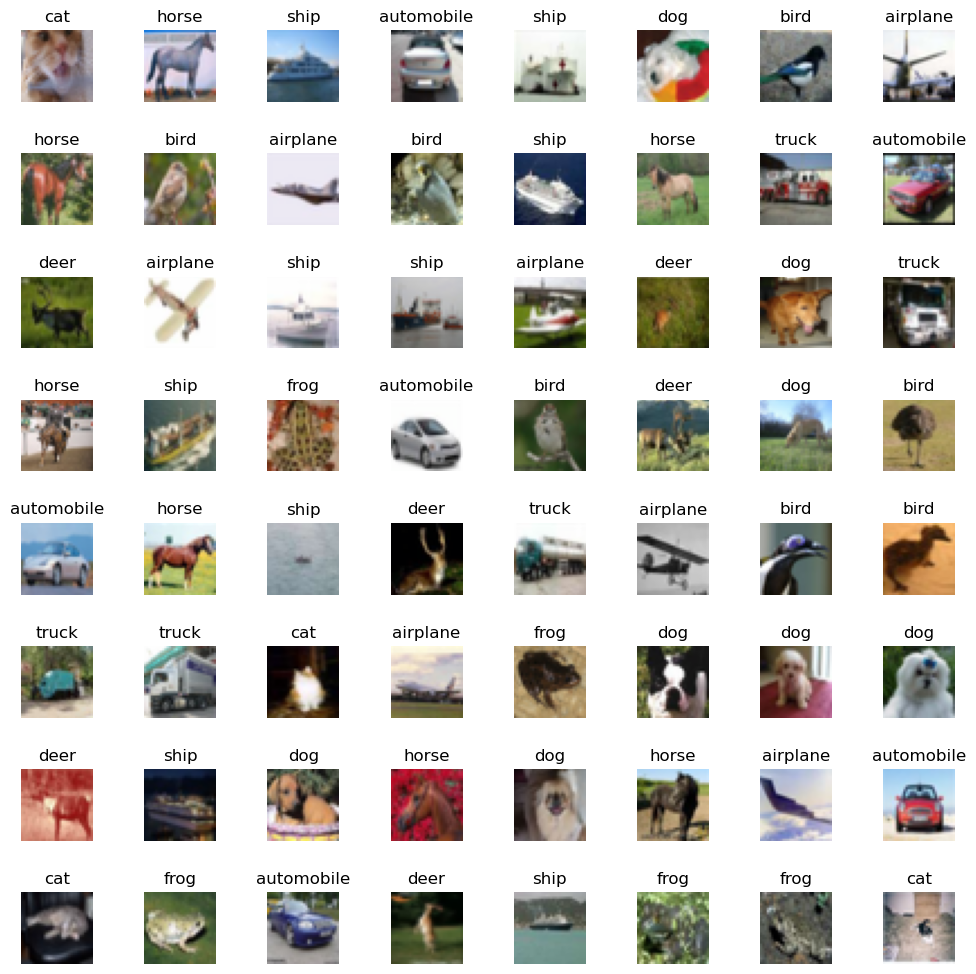

In [7]:
show_batch(train_loader)

In [8]:
num_classes = 10

## Define helper functions for training and metrics

You will need these again and again. 

In [9]:
## TODO: write a function that calculates the accuracy

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct/total

In [10]:
## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 

def train(dataloader, optimizer, model, loss_fn, device):
    """ method to train the model """
    # TODO: refine the training function from above
    # it should contain:
    # - saving of losses
    # - calculation of accuracy
    # - returning the mean loss and accuracy


    model.train()
    train_losses = []
    correct_predictions = 0
    total_samples = 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X)
        predicted_labels = torch.argmax(outputs, dim=1)
        
        # Compute loss
        loss = loss_fn(outputs, y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Store the loss for the current batch
        train_losses.append(loss.item())
        correct_predictions += (predicted_labels == y).sum().item()
        total_samples += y.size(0)
    
    # Compute the mean loss for the epoch
    mean_loss = sum(train_losses) / len(train_losses)
    accuracy = correct_predictions / total_samples
    
    return mean_loss, accuracy



#####

def validate(dataloader, optimizer, model, loss_fn, device):
    """ method to compute the metrics on the validation set """
    # Array to store losses for each batch in the validation set
    val_losses = []
    # introduce 2 new variables for accuracy
    correct_predictions = 0
    total_samples = 0

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Iterate over validation set
        for x, y in dataloader:
            # Compute loss on validation set
            y_pred = model(x.to(device))
            loss = loss_fn(y_pred, y.to(device))
            
            # Store loss for current data
            val_losses.append(loss.item())
            
            # Update correct predictions and total samples
            predicted_labels = y_pred.argmax(dim=1)
            correct_predictions += (predicted_labels == y.to(device)).sum().item()
            total_samples += y.size(0)

    # Compute mean loss for validation set
    mean_loss = sum(val_losses) / len(val_losses)
    
    # Compute accuracy for validation set
    accuracy = correct_predictions / total_samples

    return mean_loss, accuracy

In [11]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange

def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    # Array to store train losses, accuracy for each epoch
    train_losses = []
    train_accs = []

    # Array to store validation losses, accuracy for each epoch
    val_losses = []
    val_accs = []

    for epoch in trange(num_epochs, desc='Epoch'):
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device)
        val_loss, val_acc = validate(val_dataloader, optimizer, model, loss_function, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
    return train_losses, val_losses, train_accs, val_accs
    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

In [12]:
# TODO: write a function to calculate and return the confusion values
def calc_confusion_values(dataloader, model, device):
    """Method to compute the confusion values on the validation set"""
    num_classes = len(dataloader.dataset.dataset.classes)
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64).to(device)

    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            _, predicted_labels = torch.max(y_pred, dim=1)
            
            predicted_labels = torch.round(predicted_labels)  # Convert predicted labels to binary

            for i in range(len(y)):
                confusion_matrix[y[i]][predicted_labels[i]] += 1

    return confusion_matrix



## Logistic Regression   

In [13]:
class LR(torch.nn.Module):
    """
    Logistic regression model inherits from the torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO: define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO: flatten the input to a suitable size for the initial layer
        x = x.view(x.size(0), -1)
        
        # TODO: run the data through the layer
        outputs = self.linear(x)
        
        return outputs

In [14]:
## TODO: Define network in the variable named 'linear_regression', put it to the device and train mode
linear_regression = LR(input_dim = 32 * 32 * 3, output_dim = num_classes)
linear_regression.to(device)
linear_regression.train()

LR(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [15]:
## Optimiser defined. We're going to use Adam since it's always the safe bet, and also for faster convergence. 
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)

### Define loss 

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in \[0, 1\] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

Hint: Due to numerical reasons, softmax and cross entropy are combined into one operation. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [16]:
# TODO: define the loss function
loss_function = nn.CrossEntropyLoss()

In [17]:
num_epochs = 20
## TODO: run training over 20 epochs
lr_train_losses, lr_val_losses, lr_train_accs, lr_val_accs = run_training(linear_regression, optimizer, loss_function, device, num_epochs, train_loader, val_loader)


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [03:12<00:00,  9.64s/it]


## Multilayer Perceptron

MLP is a network which consists of several linear fully-connected layers with non-linearities between them.

### Question:
Why are non-linearities between linear layers important?

### Answer:
Without non-linearities, the model would be limited to representing only linear relationships between the input and output. Introducing non-linearities allows the model to learn and represent complex, non-linear relationships and patterns in the data, greatly increasing its expressiveness.
Additional arguments are: Linearity is in most cases not enough to map to non-linear decision spaces. Also, by introducing non-linearities and multiple layers we introduce regularization und thus generalizability to unseen data (prevent overfitting).

In [18]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, 1650)
        self.fc2 = nn.Linear(1650, 512)
        self.fc3 = nn.Linear(512, 138)
        self.fc4 = nn.Linear(138, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)  # Flatten the input
        
        out = self.relu(self.fc1(xb))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        
        return out

In [19]:
## TODO: Define network, put it to device and train mode
mlp = MLP(input_dim = 32 * 32 * 3, output_dim = num_classes).to(device)

# Set the model to training mode
mlp.train()

MLP(
  (fc1): Linear(in_features=3072, out_features=1650, bias=True)
  (fc2): Linear(in_features=1650, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=138, bias=True)
  (fc4): Linear(in_features=138, out_features=10, bias=True)
  (relu): ReLU()
)

In [20]:
## TODO: Define optimizer and loss functions
# Define the optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)

# Define the loss function

In [21]:
## TODO: Train the MLP over 20 epochs
num_epochs = 20

## TODO: run training over 20 epochs
mlp_train_losses, mlp_val_losses, mlp_train_accs, mlp_val_accs = run_training(mlp, optimizer, loss_function, device, num_epochs, train_loader, val_loader)


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [04:11<00:00, 12.59s/it]


## Add L2 regularisation

In [22]:
# TODO: Define new model, optimizer, put model to device, etc.
## 0.0005 is a good starting point for the regularization strength
mlp = MLP(32*32*3, num_classes).to(device).train()
optimizer = torch.optim.Adam(mlp.parameters(), weight_decay=0.0005)

l2_train_losses, l2_val_losses, l2_train_accs, l2_val_accs = run_training(mlp, optimizer, loss_function, device, num_epochs, train_loader, val_loader)


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [03:45<00:00, 11.26s/it]


In [23]:
## TODO: Retrain new model with regularization over 20 epochs

## LeNet5

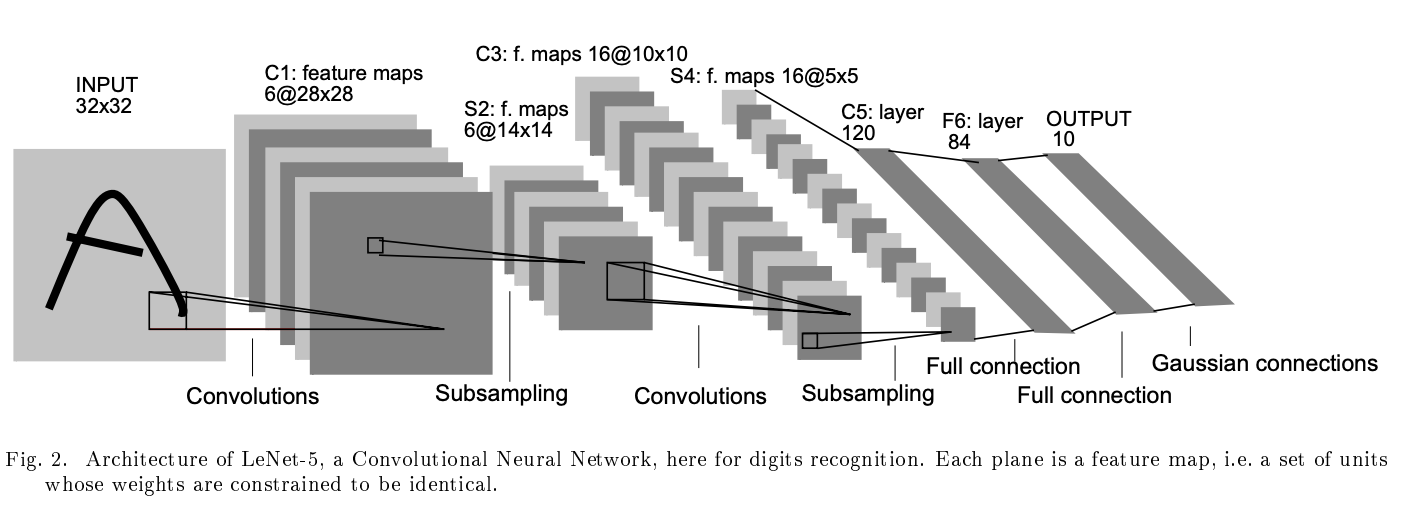

Let's implememt one of the classical convolutional network and apply it for CIFA10. Here is the link for the [original paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf) of LeNet5 introduced by Yann LeCun and colleagues in 1998. The original implentation of LeNet5 has Tanh as non-linearities. In 2012, AlexNet famously set off the deep learning revolution. AlexNet is based on LeNet, with two main innovations: (1) making it deeper by adding a few extra layers and (2) replacing the tanh activation functions by ReLU to improve training. Here we'll the original LeNet5 architecture to keep the compute requirements small, but work with the more modern ReLU activation functions.

One more thing we change in the original network is the number of input channels as LeNet5 was designed for grayscale MNIST dataset, where each picture has 1 channel, while for RGB pictures we have 3 channels in the input data.


In [24]:
class LeNet5(nn.Module):

    def __init__(self, n_classes, in_channels=1):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            ## TODO: add remaining layers, pooling and nonlinearities up to layer C5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            ## TODO: add ReLU nonlinearity and final classification linear layer
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [25]:
## TODO: define network, put it to the device and train mode
lenet5 = LeNet5(num_classes, in_channels=3).to(device).train()


In [26]:
## TODO: define loss function and optimisers
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.001)

In [27]:
## TODO: train with 20 epochs
num_epochs = 20
lenet5_train_losses, lenet5_val_losses, lenet5_train_accs, lenet5_val_accs = run_training(lenet5, optimizer, loss_function, device, num_epochs, train_loader, val_loader)

Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 20/20 [03:36<00:00, 10.84s/it]


## Analysis 

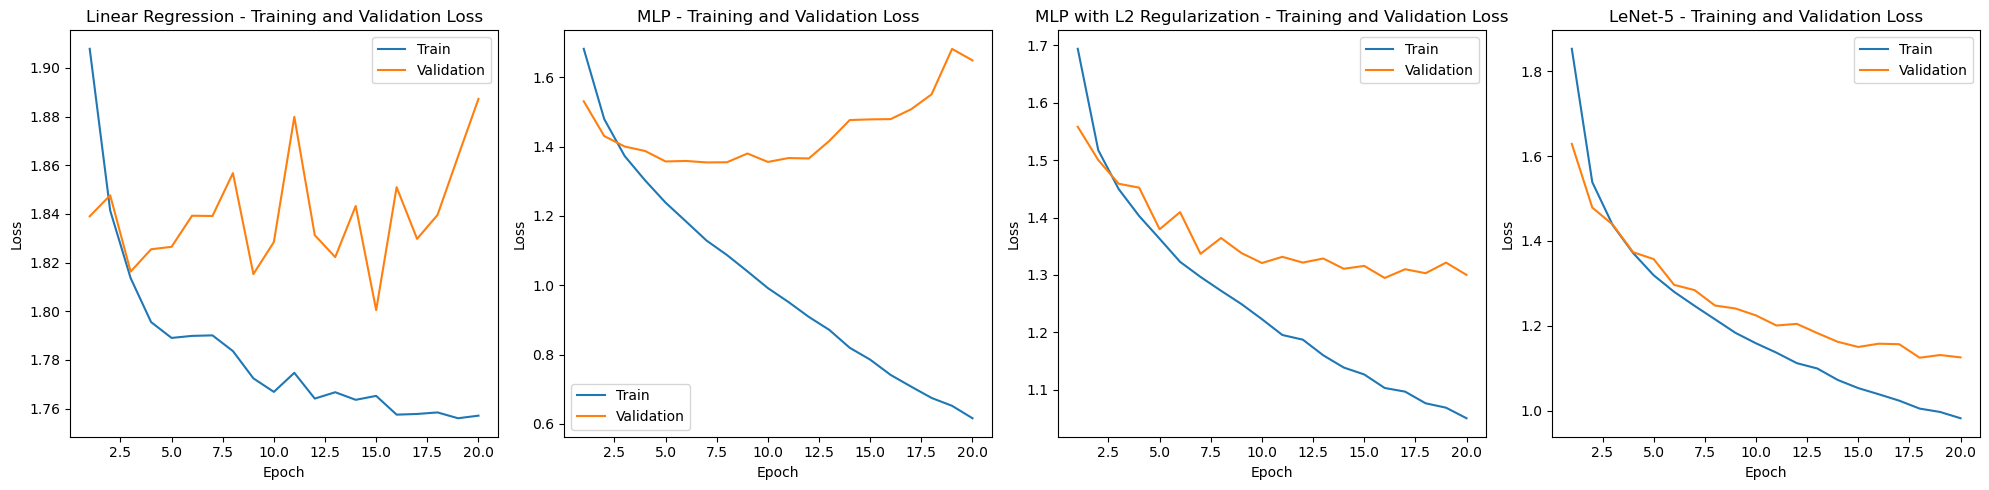

In [28]:
## TODO: Plot both train and val losses for all models. 
## What do you see?

def plot_losses(train_losses, val_losses, model_names):
    fig, axes = plt.subplots(1, len(model_names), figsize=(20, 5))
    
    for i, model_name in enumerate(model_names):
        axes[i].plot(range(1, num_epochs + 1), train_losses[i], label='Train')
        axes[i].plot(range(1, num_epochs + 1), val_losses[i], label='Validation')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Loss')
        axes[i].set_title(f'{model_name} - Training and Validation Loss')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

model_names = ['Linear Regression', 'MLP', 'MLP with L2 Regularization', 'LeNet-5']
train_losses = [lr_train_losses, mlp_train_losses, l2_train_losses, lenet5_train_losses]
val_losses = [lr_val_losses, mlp_val_losses, l2_val_losses, lenet5_val_losses]

plot_losses(train_losses, val_losses, model_names)


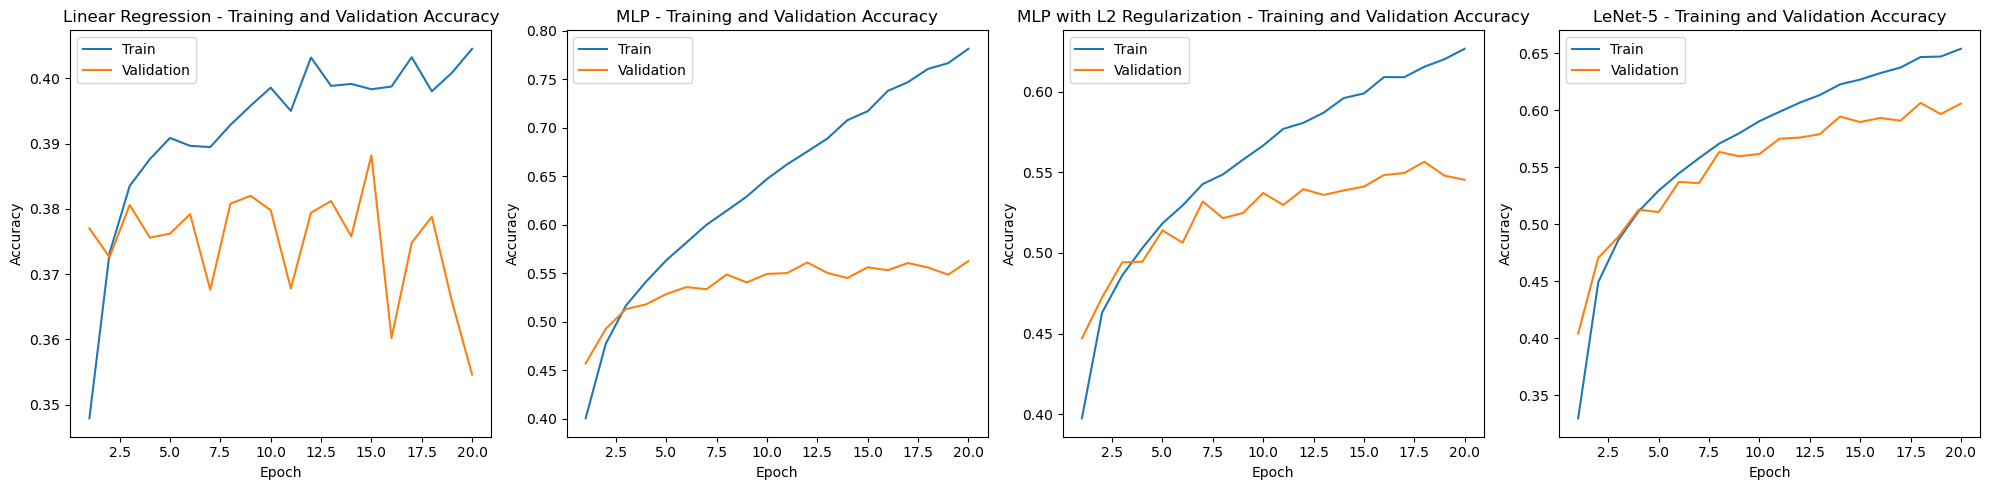

In [29]:
## TODO: Plot both train and val accuracies for all models. 
## What do you see?

def plot_accuracies(train_accs, val_accs, model_names):
    fig, axes = plt.subplots(1, len(model_names), figsize=(20, 5))
    
    for i, model_name in enumerate(model_names):
        axes[i].plot(range(1, num_epochs + 1), train_accs[i], label='Train')
        axes[i].plot(range(1, num_epochs + 1), val_accs[i], label='Validation')
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel('Accuracy')
        axes[i].set_title(f'{model_name} - Training and Validation Accuracy')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

model_names = ['Linear Regression', 'MLP', 'MLP with L2 Regularization', 'LeNet-5']
train_accs = [lr_train_accs, mlp_train_accs, l2_train_accs, lenet5_train_accs]
val_accs = [lr_val_accs, mlp_val_accs, l2_val_accs, lenet5_val_accs]

plot_accuracies(train_accs, val_accs, model_names)


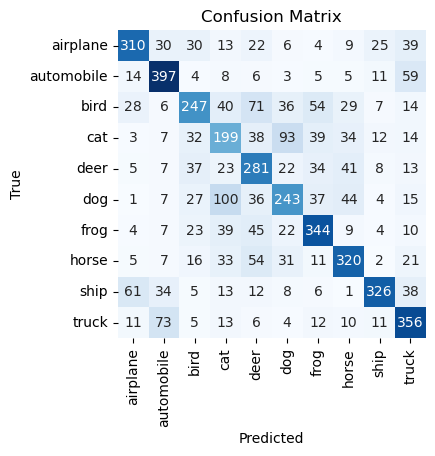

In [30]:
## TODO: Plot the confusion matrix for LeNet5
def plot_confusion_matrix(confusion_matrix):
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
                xticklabels=class_labels, yticklabels=class_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    plt.show()

# Calculate confusion matrix
confusion_matrix = calc_confusion_values(val_loader, lenet5, device)

# Plot confusion matrix
plot_confusion_matrix(confusion_matrix.cpu().numpy())

## Questions
* How did regularization change the performance of the MLP? Why?

-> MLPs Training loss decreased while its validation loss rather didnt. Hence, MLP suffered from overfitting. As explained in practical 1 regularization does smooth out the details of the model that is fitted to the training data, making it more generalizable (if it is working as intended).  

* Explain the confusion matrix for LeNet5. What do you see there?

-> The confusion matrix tells us how many times which predicted label was chosen for each true label. 
-> The row indicates the true label, the column which label has been predicted
-> The Elements on the diagonal are the number of times the correct attributed label has been predicted per label. 
-> The elemnts in the row (except for the diagonal element) are the elements that have been failed to be attributed to the element indicated by the row
(((-> The elements in one column (expect for the diagonal element of course) are the elements that have falsely been attributed to the label indicated by row. )))
-> if the model works perfect, then the proportion of the element of the diagonal to the sum of the row would be one. and the proportion of the off diagonal elements to the sum of the row would be zero.
-> As can be seen this model works actually really well, however it struggles a bit by differentiating between dogs and cats, as these have many features in common.

* Explain the difference in peformance between linear regression, MLP, and LeNet5.

-> linear regression is not able to learn non linear relationships.
-> MLP can learn non linear relationships, but is not able properly utilize spatial information that is given in images
-> LeNet5 can utilize as the convolation window somewhat notices similarities between pixels spatial depencies

* Why are convolutions better suited for pictures? Which properties of images do they exploit?

-> the "convolution window" doesn't drop the spatial alignment of the pixels 

* Is it important to redefine an optimizer for each different model, training? What about loss functions?

-> if we use a different kind of model and/or different levels of hyperparameters (e.g. change in learning rate), then yes, we need to redifine the optimizer for each model.
-> if they all share the loss function (as we have here), we can use the same. 

## Additional experiments (Optional)
* Try to replace CIFAR10 dataset with MNIST. What do you notice? Why? Try to explain the differences in terms of variance or dataset complexity
